In [1]:
#%pip install datasets
#%pip install pydub
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import tensorflow as tf

import librosa
import librosa.display
import IPython.display as ipd

from glob import glob
from IPython.display import Audio
from itertools import cycle
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
plt.style.use('ggplot')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [2]:
TESS = '/TESS Toronto emotional speech set data/'
# RAVDESS = '/RAVDESS Emotional speech audio/'
# CREMA = '/CREMA-D/'
# SAVEE = '/SAVEE/'
# JL = '/JL corpus/'
# EMOV = '/EMOV/'
# ESD = '/ESD/'
# ESD_F = '/ESD-F/'
# ASVP_ESD = '/ASVP-ESD/'
# DESD = '/DESD-E/'

In [3]:

# Specify the directory containing the TESS dataset
TESS = "/Users/phil/Desktop/CNN_LSTM/TESS Toronto emotional speech set data"  # Update this with the correct path

# Fetch list of directories in the TESS dataset
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = []

# Define emotion mappings
emotion_dic = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust' : 'disgust',
}

# Process each directory and audio file in TESS
for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        # Split file name and extract emotion key
        part = audio_file.split('.')[0]
        parts = part.split('_')
        
        # Ensure there are at least 3 parts (filename format: "ID_emotion_num.wav")
        if len(parts) > 2:  
            key = parts[2]  # Extract the emotion part (third part of the filename)
            if key in emotion_dic:  # Check if the extracted emotion exists in the dictionary
                path_list.append(f"{TESS}/{directory}/{audio_file}")
                gender_list.append('female')  # TESS is a female-only dataset
                emotion_list.append(emotion_dic[key])
        else:
            print(f"Skipping file with unexpected format: {audio_file}")  # Optionally log or print skipped files

# Create DataFrame
tess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

# Limit to 200 instances per emotion
emotions_to_limit = ['angry', 'happy', 'neutral', 'sad']

for emotion in emotions_to_limit:
    emotion_rows = tess_df[(tess_df['sex'] == 'female') & (tess_df['emotion'] == emotion)]
    
    # If there are more than 200 instances, remove some
    if len(emotion_rows) > 200:
        # Get the indices of the instances to remove
        indices_to_remove = emotion_rows.sample(len(emotion_rows) - 200).index
        
        # Drop these instances
        tess_df = tess_df.drop(indices_to_remove)

# View the first few rows of the DataFrame
print(tess_df.head())

# View emotion distribution
print(tess_df['emotion'].value_counts())


Skipping file with unexpected format: YAF_disgust
Skipping file with unexpected format: OAF_happy
Skipping file with unexpected format: YAF_sad
Skipping file with unexpected format: YAF_happy
Skipping file with unexpected format: YAF_neutral
Skipping file with unexpected format: OAF_Fear
Skipping file with unexpected format: OAF_angry
Skipping file with unexpected format: YAF_fear
Skipping file with unexpected format: OAF_neutral
Skipping file with unexpected format: OAF_disgust
Skipping file with unexpected format: YAF_angry
Skipping file with unexpected format: OAF_Sad
                                                path     sex  emotion
0  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  female  disgust
1  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  female  disgust
2  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  female  disgust
3  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  female  disgust
4  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  female  disgust
em

In [4]:
# ravdess_dir_lis = os.listdir(RAVDESS)
# path_list = []
# gender_list = []
# emotion_list = []

# emotion_dic = {
#     '03' : 'happy',
#     '01' : 'neutral',
#     '04' : 'sad',
#     '05' : 'angry',
#     '06' : 'fear',
#     '07' : 'disgust',
# }

# for directory in ravdess_dir_lis:
#     actor_files = os.listdir(os.path.join(RAVDESS, directory))
#     for audio_file in actor_files:
#         part = audio_file.split('.')[0]
#         key = part.split('-')[2]
#         if key in emotion_dic:
#             gender_code = int(part.split('-')[6])
#             path_list.append(f"{RAVDESS}{directory}/{audio_file}")
#             gender_list.append('female' if gender_code & 1 == 0 else 'male')
#             emotion_list.append(emotion_dic[key])

# ravdess_df = pd.concat([
#     pd.DataFrame(path_list, columns=['path']),
#     pd.DataFrame(gender_list, columns=['sex']),
#     pd.DataFrame(emotion_list, columns=['emotion'])
# ], axis=1)

# ravdess_df.head()


In [5]:
# crema_dir_list = os.listdir(CREMA)
# path_list = []
# gender_list = []
# emotion_list = []

# emotion_dic = {
#     'HAP' : 'happy',
#     'NEU' : 'neutral',
#     'SAD' : 'sad',
#     'ANG' : 'angry',
#     'FEA' : 'fear',
#     'DIS' : 'disgust',
# }

# female_id_list = [
#     '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018',
#     '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047',
#     '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072',
#     '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
# ]

# for audio_file in crema_dir_list:
#     part = audio_file.split('_')
#     key = part[2]
#     if key in emotion_dic:
#         path_list.append(f"{CREMA}{audio_file}")
#         gender_list.append('female' if part[0] in female_id_list else 'male')
#         emotion_list.append(emotion_dic[key])

# crema_df = pd.concat([
#     pd.DataFrame(path_list, columns=['path']),
#     pd.DataFrame(gender_list, columns=['sex']),
#     pd.DataFrame(emotion_list, columns=['emotion'])
# ], axis=1)

# crema_df.head()


In [6]:
# savee_dir_list = os.listdir(SAVEE)
# path_list = []
# gender_list = []
# emotion_list = []

# emotion_dic = {
#     'h'  : 'happy',
#     'n'  : 'neutral',
#     'sa' : 'sad',
#     'a'  : 'angry',
#     'f'  : 'fear',
#     'd'  : 'disgust'
# }

# for audio_file in savee_dir_list:
#     part = audio_file.split('_')[1]
#     key = part[:-6]
#     if key in emotion_dic:
#         path_list.append(f"{SAVEE}{audio_file}")
#         gender_list.append('male') # male only dataset
#         emotion_list.append(emotion_dic[key])

# savee_df = pd.concat([
#     pd.DataFrame(path_list, columns=['path']),
#     pd.DataFrame(gender_list, columns=['sex']),
#     pd.DataFrame(emotion_list, columns=['emotion'])
# ], axis=1)

# savee_df.head()


In [7]:
# savee_dir_list = os.listdir(SAVEE)
# path_list = []
# gender_list = []
# emotion_list = []

# emotion_dic = {
#     'h'  : 'happy',
#     'n'  : 'neutral',
#     'sa' : 'sad',
#     'a'  : 'angry',
#     'f'  : 'fear',
#     'd'  : 'disgust'
# }

# for audio_file in savee_dir_list:
#     part = audio_file.split('_')[1]
#     key = part[:-6]
#     if key in emotion_dic:
#         path_list.append(f"{SAVEE}{audio_file}")
#         gender_list.append('male') # male only dataset
#         emotion_list.append(emotion_dic[key])

# savee_df = pd.concat([
#     pd.DataFrame(path_list, columns=['path']),
#     pd.DataFrame(gender_list, columns=['sex']),
#     pd.DataFrame(emotion_list, columns=['emotion'])
# ], axis=1)

# savee_df.head()

In [8]:


# Specify the directory containing the JL dataset
JL = "/Users/phil/Desktop/CNN_LSTM/TESS Toronto emotional speech set data"  # Update with the actual path to your JL dataset

# Fetch list of audio files in the JL dataset
JL_dir_list = os.listdir(JL)
path_list = []
gender_list = []
emotion_list = []

# Define emotion mappings
emotion_dic = {
    'happy'   : 'happy',
    'sad'     : 'sad',
    'angry'   : 'angry',
    'neutral' : 'neutral',
    'excited' : 'happy',
}

# Process each audio file
for audio_file in JL_dir_list:
    parts = audio_file.split('_')
    
    # Ensure there are enough parts in the filename (at least 2 parts: gender and emotion)
    if len(parts) > 1:
        gender = parts[0]
        emotion = parts[1]
        
        # Check if the emotion is valid
        if emotion in emotion_dic:
            path_list.append(f"{JL}/{audio_file}")  # Correct path construction
            
            # Assign gender to 'female' or 'male' explicitly
            if gender == 'female':
                gender_list.append('female')
            elif gender == 'male':
                gender_list.append('male')
            else:
                print(f"Skipping file with unexpected gender: {audio_file}")
                continue  # Skip files with unexpected gender
            
            # Append the mapped emotion to the list
            emotion_list.append(emotion_dic[emotion])
        else:
            print(f"Skipping file with unknown emotion: {audio_file}")
    else:
        print(f"Skipping file with unexpected format: {audio_file}")

# Create DataFrame
JL_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

# Display the first few rows
print(JL_df.head())


Skipping file with unknown emotion: YAF_disgust
Skipping file with unknown emotion: OAF_Pleasant_surprise
Skipping file with unexpected gender: OAF_happy
Skipping file with unexpected gender: YAF_sad
Skipping file with unexpected format: TESS Toronto emotional speech set data
Skipping file with unexpected gender: YAF_happy
Skipping file with unexpected gender: YAF_neutral
Skipping file with unknown emotion: OAF_Fear
Skipping file with unexpected gender: OAF_angry
Skipping file with unknown emotion: YAF_pleasant_surprised
Skipping file with unknown emotion: YAF_fear
Skipping file with unexpected gender: OAF_neutral
Skipping file with unknown emotion: OAF_disgust
Skipping file with unexpected gender: YAF_angry
Skipping file with unknown emotion: OAF_Sad
                                                path  sex emotion
0  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  NaN     NaN
1  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  NaN     NaN
2  /Users/phil/Desktop/CNN_LSTM/TESS Tor

In [9]:


# Specify the directory containing the EMOV dataset
EMOV = "/Users/phil/Desktop/CNN_LSTM/TESS Toronto emotional speech set data"  # Update with the actual path to your EMOV dataset

# Fetch list of audio files in the EMOV dataset
emov_dir_list = os.listdir(EMOV)
path_list = []
gender_list = []
emotion_list = []

# Define emotion mappings
emotion_dic = {
    'disgust'   : 'disgust',
    'anger'     : 'angry',  # Corrected to match the emotion dictionary
}

# Process each audio file
for audio_file in emov_dir_list:
    parts = audio_file.split('_')
    
    # Ensure there are at least 2 parts in the filename (gender_emotion_number)
    if len(parts) > 1:
        gender = parts[0]  # First part is assumed to be gender
        emotion = parts[1]  # Second part is assumed to be emotion
        
        # Check if the emotion is valid according to the emotion dictionary
        if emotion in emotion_dic:
            path_list.append(f"{EMOV}/{audio_file}")  # Correct path construction
            
            # Explicitly check for gender
            if gender == 'female':
                gender_list.append('female')
            elif gender == 'male':
                gender_list.append('male')
            else:
                print(f"Skipping file with unexpected gender: {audio_file}")
                continue  # Skip files with unexpected gender
            
            # Append the mapped emotion to the list
            emotion_list.append(emotion_dic[emotion])
        else:
            print(f"Skipping file with unknown emotion: {audio_file}")
    else:
        print(f"Skipping file with unexpected format: {audio_file}")

# Create DataFrame
EMOV_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

# Display the first few rows
print(EMOV_df.head())


Skipping file with unexpected gender: YAF_disgust
Skipping file with unknown emotion: OAF_Pleasant_surprise
Skipping file with unknown emotion: OAF_happy
Skipping file with unknown emotion: YAF_sad
Skipping file with unexpected format: TESS Toronto emotional speech set data
Skipping file with unknown emotion: YAF_happy
Skipping file with unknown emotion: YAF_neutral
Skipping file with unknown emotion: OAF_Fear
Skipping file with unknown emotion: OAF_angry
Skipping file with unknown emotion: YAF_pleasant_surprised
Skipping file with unknown emotion: YAF_fear
Skipping file with unknown emotion: OAF_neutral
Skipping file with unexpected gender: OAF_disgust
Skipping file with unknown emotion: YAF_angry
Skipping file with unknown emotion: OAF_Sad
                                                path  sex emotion
0  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  NaN     NaN
1  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  NaN     NaN


In [10]:


# Specify the directory containing the ESD dataset
ESD = "/Users/phil/Desktop/CNN_LSTM/TESS Toronto emotional speech set data"  # Update with the actual path to your ESD dataset

# Fetch list of audio files in the ESD dataset
ESD_dir_list = os.listdir(ESD)
path_list = []
gender_list = []
emotion_list = []

# Define emotion mappings
emotion_dic = {
    'happy'   : 'happy',
    'angry'   : 'angry',
    'anger'   : 'angry',
    'neutral' : 'neutral',
    'sad'     : 'sad'
}

# Process each audio file
for audio_file in ESD_dir_list:
    parts = audio_file.split('_')
    
    # Ensure there are at least 2 parts in the filename (gender_emotion_number)
    if len(parts) > 1:
        gender = parts[0]  # First part is assumed to be gender
        emotion = parts[1]  # Second part is assumed to be emotion
        
        # Check if the emotion is valid according to the emotion dictionary
        if emotion in emotion_dic:
            path_list.append(f"{ESD}/{audio_file}")  # Correct path construction
            
            # Explicitly check for gender
            if gender == 'female':
                gender_list.append('female')
            elif gender == 'male':
                gender_list.append('male')
            else:
                print(f"Skipping file with unexpected gender: {audio_file}")
                continue  # Skip files with unexpected gender
            
            # Append the mapped emotion to the list
            emotion_list.append(emotion_dic[emotion])
        else:
            print(f"Skipping file with unknown emotion: {audio_file}")
    else:
        print(f"Skipping file with unexpected format: {audio_file}")

# Create DataFrame
ESD_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

# Display the first few rows
print(ESD_df.head())


Skipping file with unknown emotion: YAF_disgust
Skipping file with unknown emotion: OAF_Pleasant_surprise
Skipping file with unexpected gender: OAF_happy
Skipping file with unexpected gender: YAF_sad
Skipping file with unexpected format: TESS Toronto emotional speech set data
Skipping file with unexpected gender: YAF_happy
Skipping file with unexpected gender: YAF_neutral
Skipping file with unknown emotion: OAF_Fear
Skipping file with unexpected gender: OAF_angry
Skipping file with unknown emotion: YAF_pleasant_surprised
Skipping file with unknown emotion: YAF_fear
Skipping file with unexpected gender: OAF_neutral
Skipping file with unknown emotion: OAF_disgust
Skipping file with unexpected gender: YAF_angry
Skipping file with unknown emotion: OAF_Sad
                                                path  sex emotion
0  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  NaN     NaN
1  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  NaN     NaN
2  /Users/phil/Desktop/CNN_LSTM/TESS Tor

In [11]:


# Specify the directory containing the ESD_F dataset
ESD_F = "/Users/phil/Desktop/CNN_LSTM/TESS Toronto emotional speech set data"  # Update with the actual path to your ESD_F dataset

# Fetch the list of audio files in the ESD_F dataset
ESD_F_dir_list = os.listdir(ESD_F)
path_list = []
gender_list = []
emotion_list = []

# Define emotion mappings
emotion_dic = {
    'happy'   : 'happy',
    'angry'   : 'angry',
    'anger'   : 'angry',
    'neutral' : 'neutral',
    'sad'     : 'sad'
}

# Process each audio file
for audio_file in ESD_F_dir_list:
    parts = audio_file.split('_')  # Split the filename by '_'
    
    # Ensure there are at least 2 parts in the filename (gender_emotion_number)
    if len(parts) > 1:
        gender = parts[0]  # First part is assumed to be gender
        emotion = parts[1]  # Second part is assumed to be emotion
        
        # Check if the emotion is valid according to the emotion dictionary
        if emotion in emotion_dic:
            path_list.append(f"{ESD_F}/{audio_file}")  # Correct path construction
            
            # Explicitly check for gender
            if gender == 'female':
                gender_list.append('female')
            elif gender == 'male':
                gender_list.append('male')
            else:
                print(f"Skipping file with unexpected gender: {audio_file}")
                continue  # Skip files with unexpected gender
            
            # Append the mapped emotion to the list
            emotion_list.append(emotion_dic[emotion])
        else:
            print(f"Skipping file with unknown emotion: {audio_file}")
    else:
        print(f"Skipping file with unexpected format: {audio_file}")

# Create DataFrame
ESD_F_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

# Display the first few rows
print(ESD_F_df.head())


Skipping file with unknown emotion: YAF_disgust
Skipping file with unknown emotion: OAF_Pleasant_surprise
Skipping file with unexpected gender: OAF_happy
Skipping file with unexpected gender: YAF_sad
Skipping file with unexpected format: TESS Toronto emotional speech set data
Skipping file with unexpected gender: YAF_happy
Skipping file with unexpected gender: YAF_neutral
Skipping file with unknown emotion: OAF_Fear
Skipping file with unexpected gender: OAF_angry
Skipping file with unknown emotion: YAF_pleasant_surprised
Skipping file with unknown emotion: YAF_fear
Skipping file with unexpected gender: OAF_neutral
Skipping file with unknown emotion: OAF_disgust
Skipping file with unexpected gender: YAF_angry
Skipping file with unknown emotion: OAF_Sad
                                                path  sex emotion
0  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  NaN     NaN
1  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  NaN     NaN
2  /Users/phil/Desktop/CNN_LSTM/TESS Tor

In [12]:
# Combine only the TESS dataset
df = pd.concat([
    tess_df  # Only add the TESS dataset
], axis=0)

# Display the first few rows of the combined DataFrame
df.head()


path     sex  emotion
0  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  female  disgust
1  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  female  disgust
2  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  female  disgust
3  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  female  disgust
4  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  female  disgust

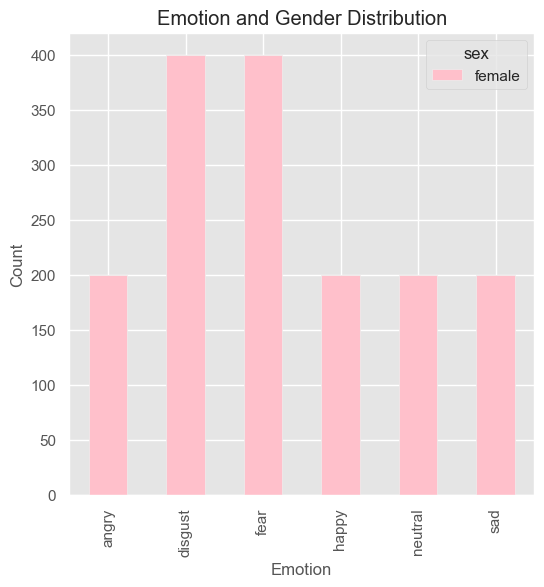

In [13]:
# Preprocessing

def plot_distribution(df):
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 6), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()

plot_distribution(df)

In [14]:
df['sex'].value_counts()

sex
female    1600
Name: count, dtype: int64

In [15]:
df.drop('sex', axis=1, inplace=True)
df.head()

path  emotion
0  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  disgust
1  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  disgust
2  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  disgust
3  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  disgust
4  /Users/phil/Desktop/CNN_LSTM/TESS Toronto emot...  disgust

In [16]:
from pydub import AudioSegment, effects

# Emotion to integer mapping
emotion_dic = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2,
    'angry'   : 3,
    'fear'    : 4,
    'disgust' : 5
}

def encode(label):
    """Encodes emotion label to integer."""
    # Return the corresponding emotion integer or None if not found
    encoded = emotion_dic.get(label, None)
    
    if encoded is None:
        print(f"Warning: Emotion '{label}' not found in the dictionary!")
    
    return encoded


## Feature Extraction

In [17]:
import numpy as np
import librosa
import random
from tqdm import tqdm

# NOISE
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.9):
    return librosa.effects.time_stretch(data,rate=rate)

# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-2, high=2) * 1000)
    return np.roll(data, shift_range)



# Combined Augmentation Function
def augment_audio(data, sr):
    augmentations = [noise, stretch, shift]  # List of augmentation functions
    applied_augmentations = random.sample(augmentations, random.randint(1, 3))

    for augmentation in applied_augmentations:
        data = augmentation(data)

    return data

# Example of using the augment_audio function
def preprocess_audio(path):
    raw_audio, sr = librosa.load(path,sr=16000)
    trimmed, _ = librosa.effects.trim(raw_audio, top_db=25, frame_length=256, hop_length=64)
    raw_audio = augment_audio(trimmed, sr)
    audio_duration=len(raw_audio)/sr
    if audio_duration > 4:
        raw_audio=raw_audio[:4*sr]
    else:
        raw_audio = np.pad(raw_audio, (0, (4*sr)-len(raw_audio)), 'constant')


    return raw_audio, sr


def preprocess_audio_aug(path):
    raw_audio, sr = librosa.load(path,sr=16000)
    trimmed, _ = librosa.effects.trim(raw_audio, top_db=25, frame_length=256, hop_length=64)
    raw_audio = augment_audio(trimmed, sr)
    audio_duration = len(raw_audio)/sr
    if audio_duration > 4:
        raw_audio = raw_audio[:4*sr]
    else:
        raw_audio = np.pad(raw_audio, (0, (4*sr)-len(raw_audio)), 'constant')


    return raw_audio, sr

# normal
def preprocess_audio_n(path):
    raw_audio, sr = librosa.load(path,sr=16000)
    raw_audio, _ = librosa.effects.trim(raw_audio, top_db=25, frame_length=256, hop_length=64)
    audio_duration = len(raw_audio)/sr
    if audio_duration > 4:
        raw_audio = raw_audio[:4*sr]
    else:
        raw_audio = np.pad(raw_audio, (0, (4*sr)-len(raw_audio)), 'constant')


    return raw_audio, sr

In [18]:
zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 400
HOP_LENGTH = 160
sr=16000

# 20 mfcc features + 1 zcr + 1 rms
for row in tqdm(df.itertuples(index=False)):
    try:
        # normal preprocessing 
        y,_= preprocess_audio_n(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))

        # augmentated preprocessing 
        y,_= preprocess_audio_aug(row.path)

        zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=HOP_LENGTH)

        zcr_list.append(zcr)
        rms_list.append(rms)
        mfccs_list.append(mfccs)

        emotion_list.append(encode(row.emotion))


        # oversample augmentated preprocessing for fear and disgust
        if row.emotion == "fear" and np.random.rand() <= 0.5 or row.emotion == "disgust" and np.random.rand() <= 0.3:
            y,_= preprocess_audio_aug(row.path)

            zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
            rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=HOP_LENGTH)

            zcr_list.append(zcr)
            rms_list.append(rms)
            mfccs_list.append(mfccs)

            emotion_list.append(encode(row.emotion))

        # y,_= preprocess_audio(row.path)

        # zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        # rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
        # mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=HOP_LENGTH)

        # zcr_list.append(zcr)
        # rms_list.append(rms)
        # mfccs_list.append(mfccs)

        # emotion_list.append(encode(row.emotion))
    except:
        print(f"Failed for path: {row.path}")

1600it [01:22, 19.51it/s]


In [19]:
#Check shape
mfccs_list[7].shape

(20, 401)

## Train test split

In [20]:
# combining the different features
X = np.concatenate((zcr_list,rms_list,mfccs_list),axis=1)
X = X.astype('float32')

y = np.asarray(emotion_list)
y = np.expand_dims(y, axis=1).astype('int8')

In [21]:
# save features
np.save('X_Extract.npy', X)
np.save('Y_Extract.npy', y)

In [22]:
# load features
X = np.load('X_Extract.npy')
y = np.load('Y_Extract.npy')

In [23]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import layers, optimizers, callbacks

In [24]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.08, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_val_class = to_categorical(y_val, 6)
y_test_class = to_categorical(y_test, 6)
y_train_class = to_categorical(y_train, 6)

X_train.shape

(3236, 22, 401)

## Metric setup


In [36]:
def summarize_history_accuracy(history):

  plt.figure(figsize=(12, 6))

  # Accuracy subplot
  plt.subplot(1, 2, 1)
  plt.plot(history.history['categorical_accuracy'])
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Loss subplot
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  plt.tight_layout()
  plt.show()

from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(xv, yv, MODEL):
    y_pred = np.argmax(MODEL.predict(xv), axis=1)
    labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
    cm = confusion_matrix(np.argmax(yv, axis=1), y_pred, labels=range(6))

    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')
    plt.show()

from tensorflow.keras.metrics import Precision, Recall, F1Score


def model_info(model, test_x, test_y):
    # Evaluate the model on validation data and get predictions
    loss, accuracy = model.evaluate(test_x, test_y)
    print("Validation Loss:", loss)
    print("Validation Accuracy:", accuracy)

    # Create metric objects
    precision = Precision(name='precision')
    recall = Recall(name='recall')
    f1_score = F1Score(name='f1_score')

    # Get model predictions
    y_pred = model.predict(test_x)

    # Update metrics with true labels and predictions
    precision.update_state(test_y, y_pred)
    recall.update_state(test_y, y_pred)
    f1_score.update_state(test_y, y_pred)

    # Print calculated metrics
    print("Precision:", precision.result().numpy())
    print("Recall:", recall.result().numpy())

    # Calculate and print F1-score for each class
    f1_scores = f1_score.result().numpy()
    emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']  # Replace with your actual labels

    for i, emotion in enumerate(emotion_labels):
        print(f"F1-Score ({emotion}):", f1_scores[i])

In [26]:
# Callbacks
# Reduce learning rate when validation categorical accuracy does not improve for 'patience' epochs
# The learning rate will be reduced by a 'factor' of 0.5 (50% reduction)
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, min_lr=1e-6, verbose=1)

# Early stopping to halt training when the validation loss doesn't improve for 'patience' epochs
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

## Audio test setup

In [33]:
path = 'OAF_back_angry.wav'


def preprocess_audio(path):
    raw_audio, sr = librosa.load(path,sr=16000)
    raw_audio, _ = librosa.effects.trim(raw_audio, top_db=25, frame_length=256, hop_length=64)
    audio_duration=len(raw_audio)/sr
    if audio_duration > 4:
        raw_audio=raw_audio[:4*sr]
    else:
        raw_audio = np.pad(raw_audio, (0, (4*sr)-len(raw_audio)), 'constant')


    return raw_audio, sr



zcr_list = []
rms_list = []
mfccs_list = []
emotion_list = []

FRAME_LENGTH = 400
HOP_LENGTH = 160
sr=16000


y,_= preprocess_audio(path)
zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=25, hop_length=HOP_LENGTH)

zcr_list.append(zcr)
rms_list.append(rms)
mfccs_list.append(mfccs)
pda = np.concatenate((zcr_list,rms_list,mfccs_list),axis=1)
pda = pda.astype('float32')

# Model training 

## LSTM

In [28]:
# Initialize the model
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1:])))
MODEL.add(layers.Dropout(0.5))  # Adding dropout for regularization
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dropout(0.5))  # Adding dropout for regularization
MODEL.add(layers.Dense(6, activation='softmax'))

# Compile the model with Adam optimizer
MODEL.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

print(MODEL.summary())

# Fit the model with the callbacks
history = MODEL.fit(X_train, y_train_class,
                    epochs=200,
                    batch_size=20,  # Increased batch size for smoother gradients
                    validation_data=(X_val, y_val_class),
                    callbacks=[rlrop, early_stopping])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 22, 64)         │       119,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,710 (596.52 KB)

 Trainable params: 152,710 (596.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - categorical_accuracy: 0.5393 - loss: 1.2582 - val_categorical_accuracy: 0.8274 - val_loss: 0.4603 - learning_rate: 0.0010
Epoch 2/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy: 0.8642 - loss: 0.4231 - val_categorical_accuracy: 0.8985 - val_loss: 0.2605 - learning_rate: 0.0010
Epoch 3/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - categorical_accuracy: 0.9166 - loss: 0.2772 - val_categorical_accuracy: 0.9086 - val_loss: 0.2374 - learning_rate: 0.0010
Epoch 4/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - categorical_accuracy: 0.9146 - loss: 0.2544 - val_categorical_accuracy: 0.9086 - val_loss: 0.2264 - learning_rate: 0.0010
Epoch 5/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy: 0.9274 - loss: 0.2317 - val_categorical_accuracy: 0.9695 - val_loss: 0.1251 - learning_rate: 0.0010
Epoch 6/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - categorical_accuracy: 0.9472 - loss: 0.1758 - val

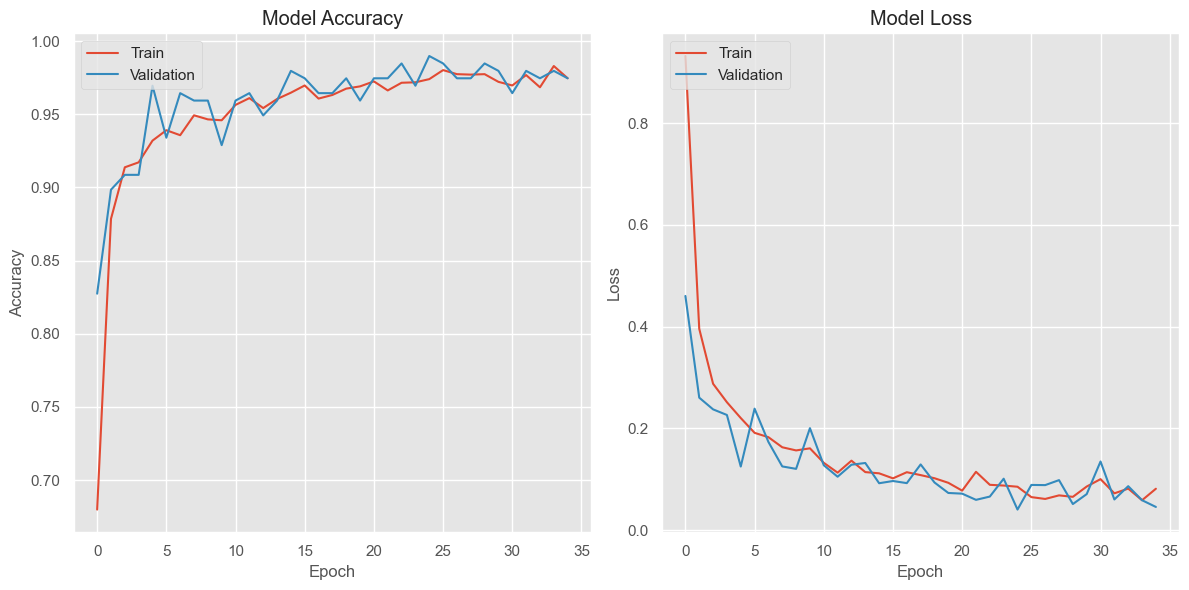

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


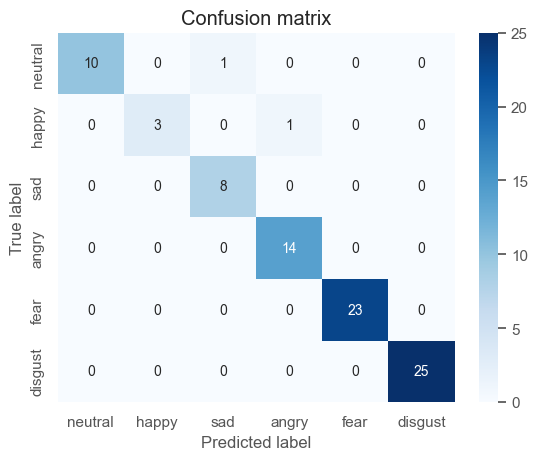

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - categorical_accuracy: 0.9882 - loss: 0.0461 
Validation Loss: 0.08341988176107407
Validation Accuracy: 0.9764705896377563
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Precision: 0.9764706
Recall: 0.9764706
F1-Score (neutral): 0.9523809
F1-Score (happy): 0.8571428
F1-Score (sad): 0.9411765
F1-Score (angry): 0.96551716
F1-Score (fear): 1.0
F1-Score (disgust): 1.0


In [38]:
summarize_history_accuracy(history)
plot_confusion_matrix(X_test, y_test_class, MODEL)
model_info(MODEL, X_test, y_test_class)
MODEL.save('model_LSTM_1_.h5')

In [39]:
pr = MODEL.predict(pda)
print(pr)
emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
predicted_emotion = emotion_labels[np.argmax(pr)]
print(predicted_emotion)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
[[1.1552357e-02 5.1231263e-03 1.4614387e-04 2.2715217e-01 7.5567526e-01
  3.5098536e-04]]
fear


In [40]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model_lstm = Sequential()
model_lstm.add(layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1:])))
model_lstm.add(layers.Dropout(0.5))  # Adding dropout for regularization
model_lstm.add(layers.LSTM(64, return_sequences=True))
model_lstm.add(layers.Dropout(0.5))  # Adding dropout for regularization
model_lstm.add(layers.LSTM(64, return_sequences=True))
model_lstm.add(layers.Dropout(0.5))  # Adding dropout for regularization
model_lstm.add(layers.LSTM(64))
model_lstm.add(layers.Dropout(0.5))  # Adding dropout for regularization

model_lstm.add(layers.Dense(128, activation='relu'))
model_lstm.add(layers.Dropout(0.5))  # Adding dropout for regularization
model_lstm.add(layers.Dense(64, activation='relu'))
model_lstm.add(layers.Dropout(0.5))  # Adding dropout for regularization
model_lstm.add(layers.Dense(6, activation='softmax'))

opt = optimizers.Adam(clipvalue=0.5)  # clipvalue to prevent exploding gradients
model_lstm.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
print(model_lstm.summary())
history = model_lstm.fit(X_train, y_train_class,epochs=200, validation_data=(X_val, y_val_class), batch_size=64, callbacks=[rlrop, early_stopping])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 22, 64)         │       119,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 22, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 22, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,334 (919.27 KB)

 Trainable params: 235,334 (919.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - categorical_accuracy: 0.3330 - loss: 1.6768 - val_categorical_accuracy: 0.4975 - val_loss: 1.1962 - learning_rate: 0.0010
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - categorical_accuracy: 0.5668 - loss: 1.1216 - val_categorical_accuracy: 0.5990 - val_loss: 0.9312 - learning_rate: 0.0010
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - categorical_accuracy: 0.6358 - loss: 0.9401 - val_categorical_accuracy: 0.7259 - val_loss: 0.6641 - learning_rate: 0.0010
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - categorical_accuracy: 0.7041 - loss: 0.7622 - val_categorical_accuracy: 0.8020 - val_loss: 0.5281 - learning_rate: 0.0010
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - categorical_accuracy: 0.7472 - loss: 0.6346 - val_categorical_accuracy: 0.8528 - val_loss: 0.4476 - learning_rate: 0.0010
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - categorical_accuracy: 0.7933 - loss: 0.5464 - val_categorical

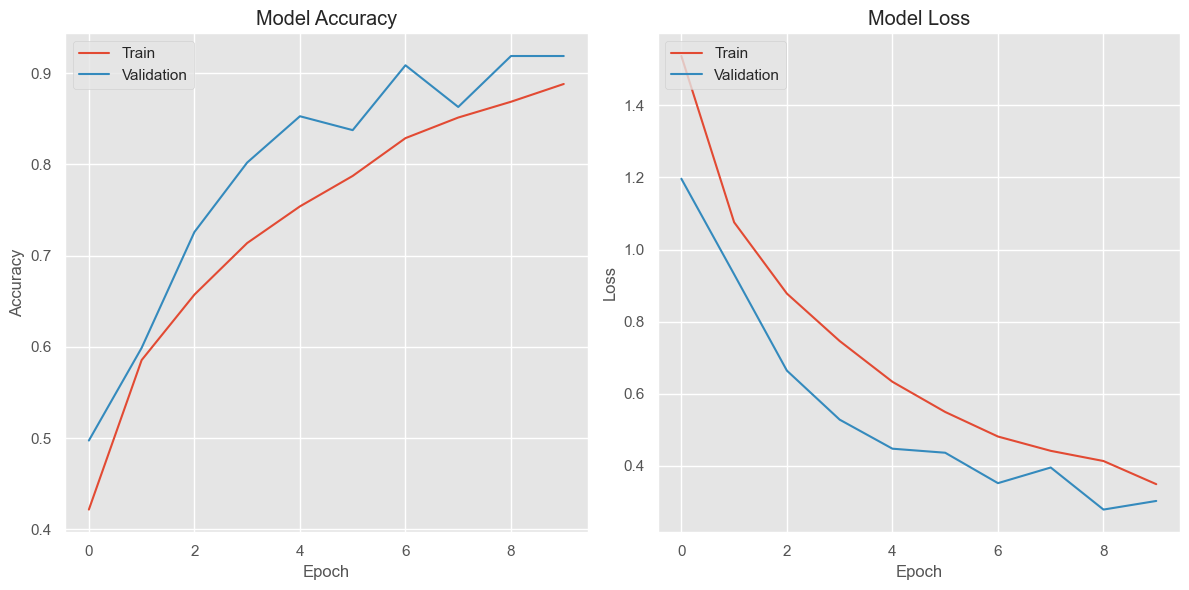

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


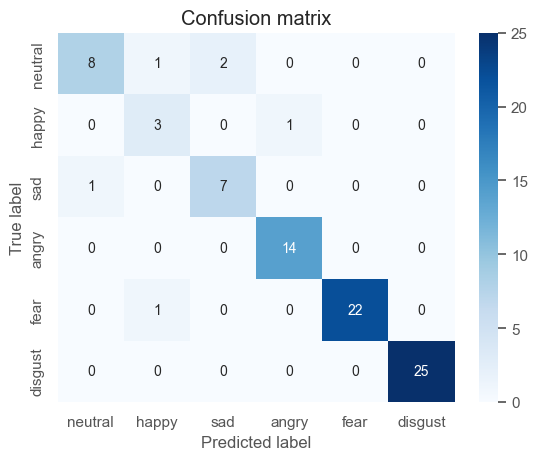

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.9217 - loss: 0.2095 
Validation Loss: 0.19005908071994781
Validation Accuracy: 0.929411768913269
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


Precision: 0.9404762
Recall: 0.92941177
F1-Score (neutral): 0.79999995
F1-Score (happy): 0.6666666
F1-Score (sad): 0.82352936
F1-Score (angry): 0.96551716
F1-Score (fear): 0.9777777
F1-Score (disgust): 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
[[2.5353751e-03 9.0001321e-01 2.0528732e-05 9.5888630e-02 7.2864920e-04
  8.1368792e-04]]
happy


In [42]:
summarize_history_accuracy(history)
plot_confusion_matrix(X_test, y_test_class, model_lstm)
model_info(model_lstm, X_test, y_test_class)
MODEL.save('model_LSTM_2_.h5')

pr = model_lstm.predict(pda)
print(pr)
emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
predicted_emotion = emotion_labels[np.argmax(pr)]
print(predicted_emotion)

## GRU

In [43]:
from tensorflow import keras
from tensorflow.keras.layers import GRU, Dropout, Dense

model_GRU = keras.Sequential([
  keras.layers.Input(shape=X_train.shape[1:]),
  keras.layers.GRU(64, return_sequences=True, dropout=0.5),  # First GRU layer
  keras.layers.BatchNormalization(),  # Normalize activations before next layer

  keras.layers.GRU(32, return_sequences=True, dropout=0.5),  # Second GRU with fewer units

  # Additional GRU layers (optional)
  keras.layers.GRU(16, return_sequences=True, dropout=0.3),  # Third GRU with even fewer units
  keras.layers.GRU(8, dropout=0.3),  # Fourth GRU layer

  # Additional normal layers (optional)
  keras.layers.Dense(64, activation='relu'),  # Dense layer with ReLU activation
  keras.layers.Dropout(0.2),  # Dropout for regularization

  keras.layers.Dense(6, activation="softmax")  # Output layer
])

model_GRU.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy'])

print(model_GRU.summary())

# Fit the model with the callbacks
history_GRU = model_GRU.fit(X_train, y_train_class,
                    epochs=200,
                    batch_size=20,  # Increased batch size for smoother gradients
                    validation_data=(X_val, y_val_class),
                    callbacks=[rlrop, early_stopping])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 22, 64)         │        89,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 22, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 22, 32)         │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 22, 16)         │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,318 (403.59 KB)

 Trainable params: 103,190 (403.09 KB)

 Non-trainable params: 128 (512.00 B)

None
Epoch 1/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - categorical_accuracy: 0.2533 - loss: 1.7269 - val_categorical_accuracy: 0.5533 - val_loss: 1.3677 - learning_rate: 0.0010
Epoch 2/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - categorical_accuracy: 0.4513 - loss: 1.4615 - val_categorical_accuracy: 0.6091 - val_loss: 1.0333 - learning_rate: 0.0010
Epoch 3/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - categorical_accuracy: 0.5598 - loss: 1.1973 - val_categorical_accuracy: 0.6599 - val_loss: 0.9198 - learning_rate: 0.0010
Epoch 4/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - categorical_accuracy: 0.6004 - loss: 1.0960 - val_categorical_accuracy: 0.6954 - val_loss: 0.8643 - learning_rate: 0.0010
Epoch 5/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - categorical_accuracy: 0.6407 - loss: 0.9810 - val_categorical_accuracy: 0.7157 - val_loss: 0.7952 - learning_rate: 0.0010
Epoch 6/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - categorical_accuracy: 0.6410 - loss: 0.9621 - val

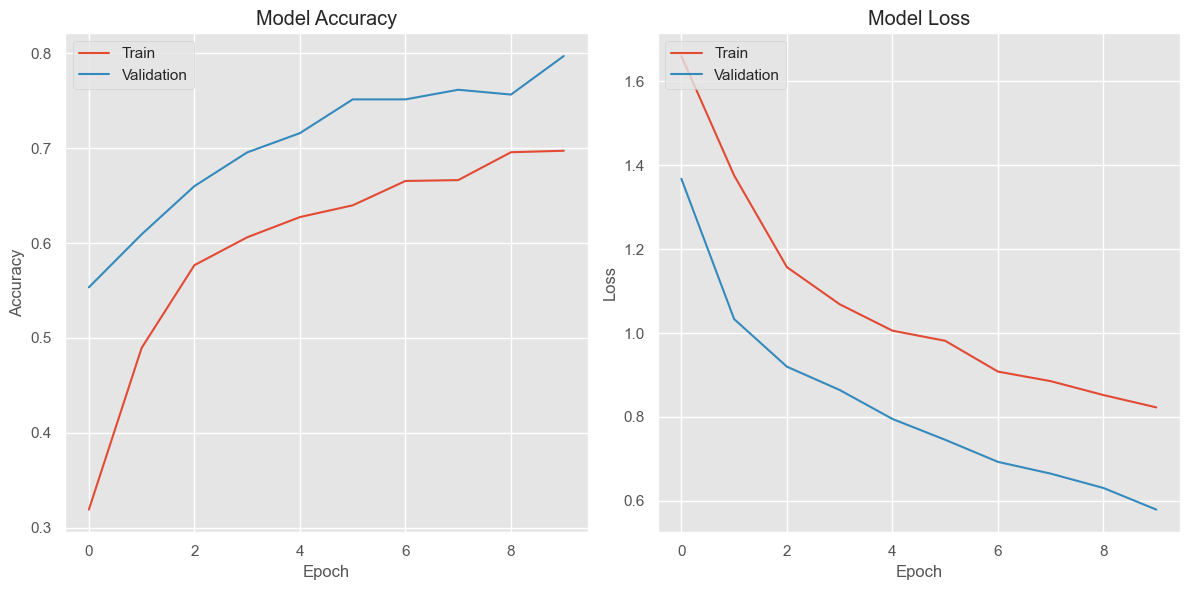

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


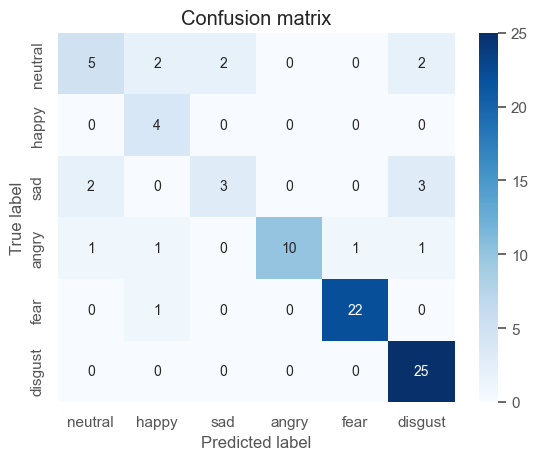

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - categorical_accuracy: 0.8239 - loss: 0.4408
Validation Loss: 0.4623892307281494
Validation Accuracy: 0.8117647171020508
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Precision: 0.9354839
Recall: 0.68235296
F1-Score (neutral): 0.5263157
F1-Score (happy): 0.6666666
F1-Score (sad): 0.4615384
F1-Score (angry): 0.8333333
F1-Score (fear): 0.9565217
F1-Score (disgust): 0.89285713


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
[[0.05270189 0.32640705 0.01049725 0.11938506 0.48573276 0.00527598]]
fear


In [44]:
summarize_history_accuracy(history_GRU)
plot_confusion_matrix(X_test, y_test_class, model_GRU )
model_info(model_GRU, X_test, y_test_class)

pr = model_GRU.predict(pda)
print(pr)
emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
predicted_emotion = emotion_labels[np.argmax(pr)]
print(predicted_emotion)

## Bi-LSTM

In [45]:
model_lstm_bi = Sequential([
  layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(X_train.shape[1:])),
  layers.Dropout(0.5),
  layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
  layers.Dropout(0.5),
  layers.Bidirectional(layers.LSTM(16)),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu'),  # Dense layer with ReLU activation
  layers.Dropout(0.2),
  layers.Dense(6, activation='softmax')  # Output layer
])


# Compile the model with Adam optimizer and gradient clipping
opt = optimizers.Adam(clipvalue=0.5)  # clipvalue to prevent exploding gradients
model_lstm_bi.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


print(model_lstm_bi.summary())

# Fit the model with the callbacks
history1 = model_lstm_bi.fit(X_train, y_train_class,
                    epochs=200,
                    batch_size=32,  # Adjusted batch size
                    validation_data=(X_val, y_val_class),
                    callbacks=[rlrop, early_stopping])


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 22, 128)        │       238,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 22, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 22, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,174 (1.13 MB)

 Trainable params: 295,174 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - categorical_accuracy: 0.3786 - loss: 1.5669 - val_categorical_accuracy: 0.7005 - val_loss: 0.7886 - learning_rate: 0.0010
Epoch 2/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - categorical_accuracy: 0.7552 - loss: 0.6691 - val_categorical_accuracy: 0.8934 - val_loss: 0.3860 - learning_rate: 0.0010
Epoch 3/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - categorical_accuracy: 0.8751 - loss: 0.3857 - val_categorical_accuracy: 0.8985 - val_loss: 0.2966 - learning_rate: 0.0010
Epoch 4/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - categorical_accuracy: 0.8854 - loss: 0.3165 - val_categorical_accuracy: 0.9188 - val_loss: 0.2401 - learning_rate: 0.0010
Epoch 5/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - categorical_accuracy: 0.9082 - loss: 0.2559 - val_categorical_accuracy: 0.9289 - val_loss: 0.2080 - learning_rate: 0.0010
Epoch 6/200
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - categorical_accuracy: 0.9184 - loss: 0.2457 - val

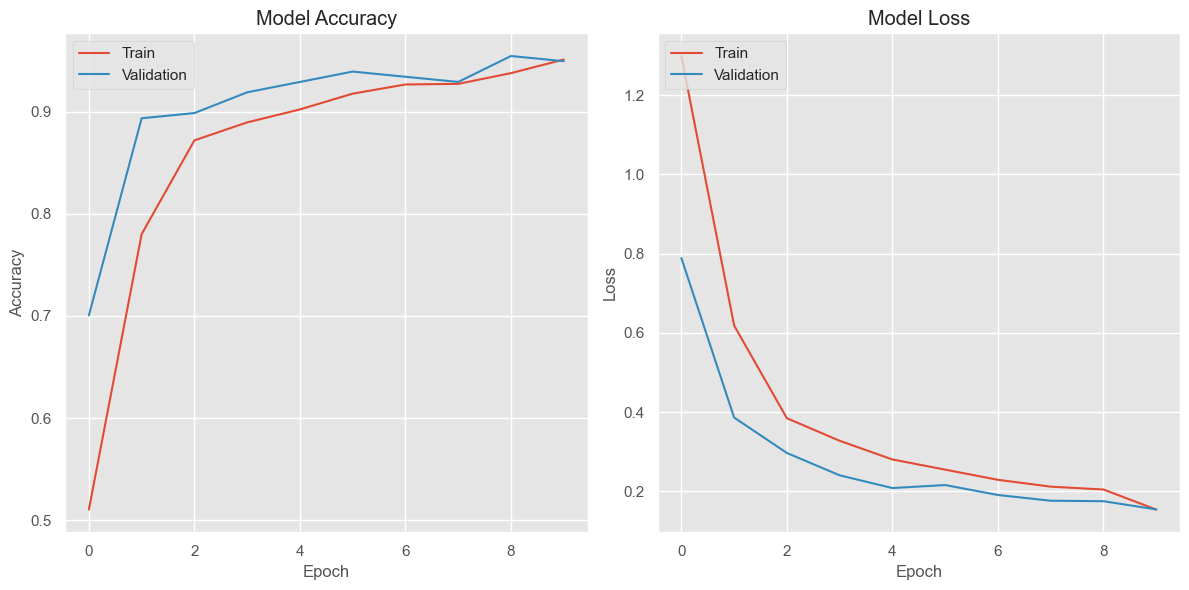

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step


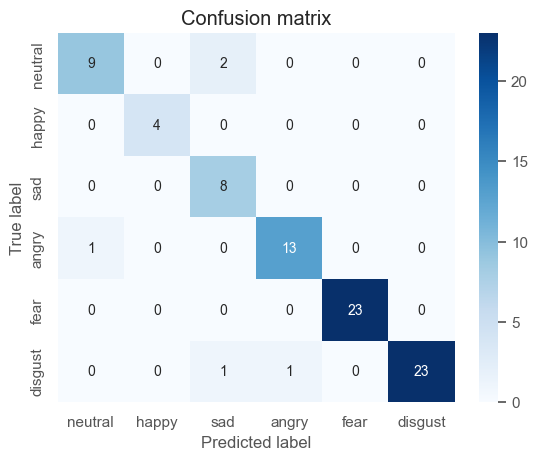

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9432 - loss: 0.1248
Validation Loss: 0.13749153912067413
Validation Accuracy: 0.9411764740943909
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Precision: 0.9411765
Recall: 0.9411765
F1-Score (neutral): 0.85714275
F1-Score (happy): 1.0
F1-Score (sad): 0.8421052
F1-Score (angry): 0.92857134
F1-Score (fear): 1.0
F1-Score (disgust): 0.95833325
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
[[2.5795078e-02 7.4247390e-02 1.1044360e-04 8.6385798e-01 3.5322785e-02
  6.6629011e-04]]
angry


In [46]:
summarize_history_accuracy(history1)
plot_confusion_matrix(X_test, y_test_class, model_lstm_bi)
model_info(model_lstm_bi, X_test, y_test_class)

pr = model_lstm_bi.predict(pda)
print(pr)
emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
predicted_emotion = emotion_labels[np.argmax(pr)]
print(predicted_emotion)

## CNN

In [47]:
import tensorflow.keras.layers as L

model_CNN = Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1:])),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    L.Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(6,activation='softmax')
])

opt = optimizers.Adam(clipvalue=0.5)  # clipvalue to prevent exploding gradients
model_CNN.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

print(model_CNN.summary())

history_CNN = model_CNN.fit(X_train, y_train_class,epochs=200, validation_data=(X_val, y_val_class), batch_size=64, callbacks=[rlrop, early_stopping])


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 22, 512)        │     1,027,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 11, 512)        │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 6, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 6, 256)         │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 3, 256)         │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2, 128)         │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         3,07

 Total params: 3,367,046 (12.84 MB)

 Trainable params: 3,362,694 (12.83 MB)

 Non-trainable params: 4,352 (17.00 KB)

None
Epoch 1/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - categorical_accuracy: 0.5664 - loss: 1.2033 - val_categorical_accuracy: 0.3147 - val_loss: 49.6807 - learning_rate: 0.0010
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - categorical_accuracy: 0.9244 - loss: 0.2018 - val_categorical_accuracy: 0.2335 - val_loss: 18.8533 - learning_rate: 0.0010
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - categorical_accuracy: 0.9621 - loss: 0.0999 - val_categorical_accuracy: 0.3756 - val_loss: 8.1387 - learning_rate: 0.0010
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - categorical_accuracy: 0.9726 - loss: 0.0776 - val_categorical_accuracy: 0.4467 - val_loss: 5.5698 - learning_rate: 0.0010
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - categorical_accuracy: 0.9816 - loss: 0.0486 - val_categorical_accuracy: 0.7970 - val_loss: 1.0608 - learning_rate: 0.0010
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - categorical_accuracy: 0.9784 - loss: 0.0603 - val_cat

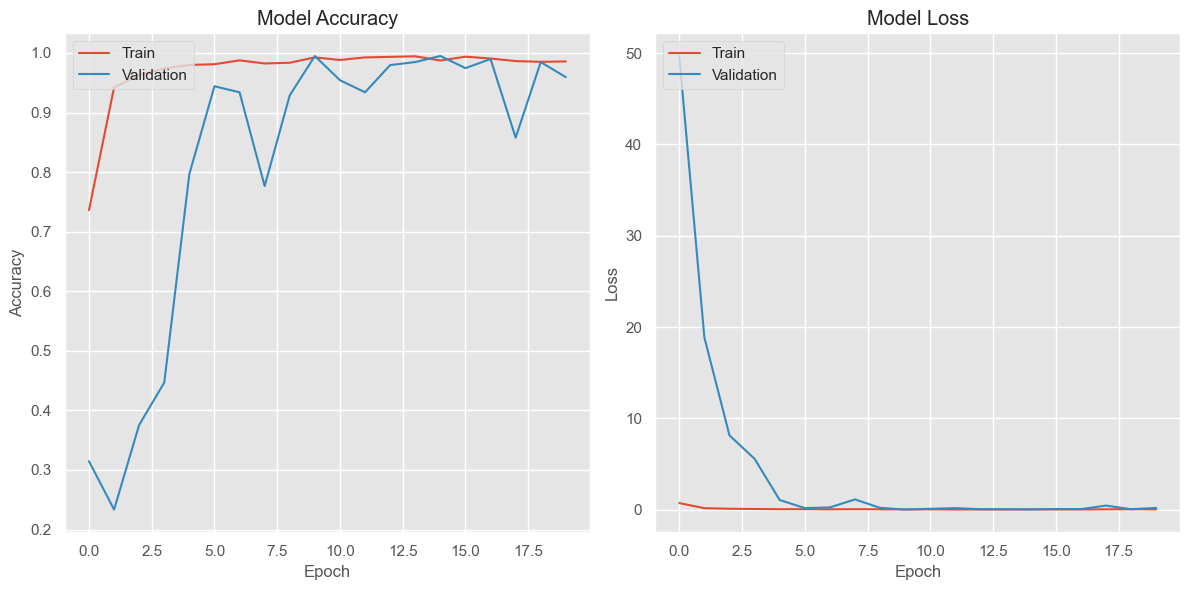

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


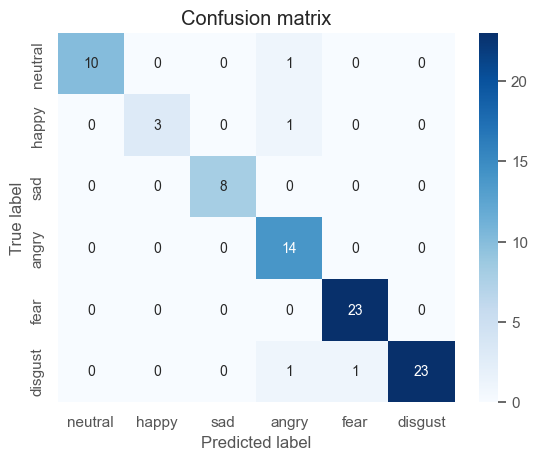

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9608 - loss: 0.0799
Validation Loss: 0.10657494515180588
Validation Accuracy: 0.9529411792755127
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Precision: 0.9529412
Recall: 0.9529412
F1-Score (neutral): 0.9523809
F1-Score (happy): 0.8571428
F1-Score (sad): 1.0
F1-Score (angry): 0.9032257
F1-Score (fear): 0.97872335
F1-Score (disgust): 0.95833325


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [60]:
summarize_history_accuracy(history_CNN)
plot_confusion_matrix(X_test, y_test_class, model_CNN)
model_info(model_CNN,X_test, y_test_class)

pr = model_CNN.predict(pda)
print(pr)
emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
predicted_emotion = emotion_labels[np.argmax(pr)]
print(predicted_emotion)

## C-LSTM

In [59]:
import tensorflow.keras.layers as L

modelCLSTM = Sequential([
    L.Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1:])),
    L.MaxPooling1D(pool_size=2, strides = 2, padding = 'same'),
    L.BatchNormalization(),
    L.Dropout(0.3),

    L.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.MaxPooling1D(pool_size=2, strides = 2, padding = 'same'),
    L.BatchNormalization(),
    L.Dropout(0.3),

    L.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    L.MaxPooling1D(pool_size=2, strides = 2, padding = 'same'),
    L.BatchNormalization(),
    L.Dropout(0.3),

    L.LSTM(128, return_sequences=True),
    L.Dropout(0.3),

    L.LSTM(128, return_sequences=True),
    L.Dropout(0.3),
    L.LSTM(128),
    L.Dropout(0.3),

    L.Dense(128, activation='relu'),
    #L.Dropout(0.3),

    L.Dense(64, activation='relu'),
    #L.Dropout(0.3),

    L.Dense(32, activation='relu'),
    #L.Dropout(0.3),

    L.Dense(6, activation='softmax')
])


opt = optimizers.Adam(clipvalue=0.5)  # clipvalue to prevent exploding gradients
modelCLSTM.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Callbacks with adjusted ReduceLROnPlateau parameters for more aggressive reduction
# rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

print(modelCLSTM.summary())

history_CLSTM = modelCLSTM.fit(X_train, y_train_class,epochs=200, validation_data=(X_val, y_val_class), batch_size=64, callbacks=[rlrop, early_stopping])

# history_CLSTM = modelCLSTM.fit(X_train, y_train_class,epochs=200, validation_data=(X_to_split, y_to_split), batch_size=64, callbacks=[rlrop, early_stopping])

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 22, 1024)       │     2,054,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 11, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 11, 1024)       │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 11, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 11, 512)        │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 6, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 6, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 6, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 6, 256)         │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 3, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 3, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,826,214 (22.23 MB)

 Trainable params: 5,822,630 (22.21 MB)

 Non-trainable params: 3,584 (14.00 KB)

None
Epoch 1/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - categorical_accuracy: 0.3237 - loss: 1.6282 - val_categorical_accuracy: 0.2690 - val_loss: 5.0823 - learning_rate: 0.0010
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - categorical_accuracy: 0.6466 - loss: 0.8732 - val_categorical_accuracy: 0.3959 - val_loss: 1.5143 - learning_rate: 0.0010
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - categorical_accuracy: 0.8529 - loss: 0.3956 - val_categorical_accuracy: 0.6954 - val_loss: 1.1130 - learning_rate: 0.0010
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - categorical_accuracy: 0.9457 - loss: 0.1905 - val_categorical_accuracy: 0.5533 - val_loss: 2.0189 - learning_rate: 0.0010
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - categorical_accuracy: 0.9622 - loss: 0.1254 - val_categorical_accuracy: 0.9492 - val_loss: 0.1660 - learning_rate: 0.0010
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - categorical_accuracy: 0.9733 - loss: 0.0787 - val_ca

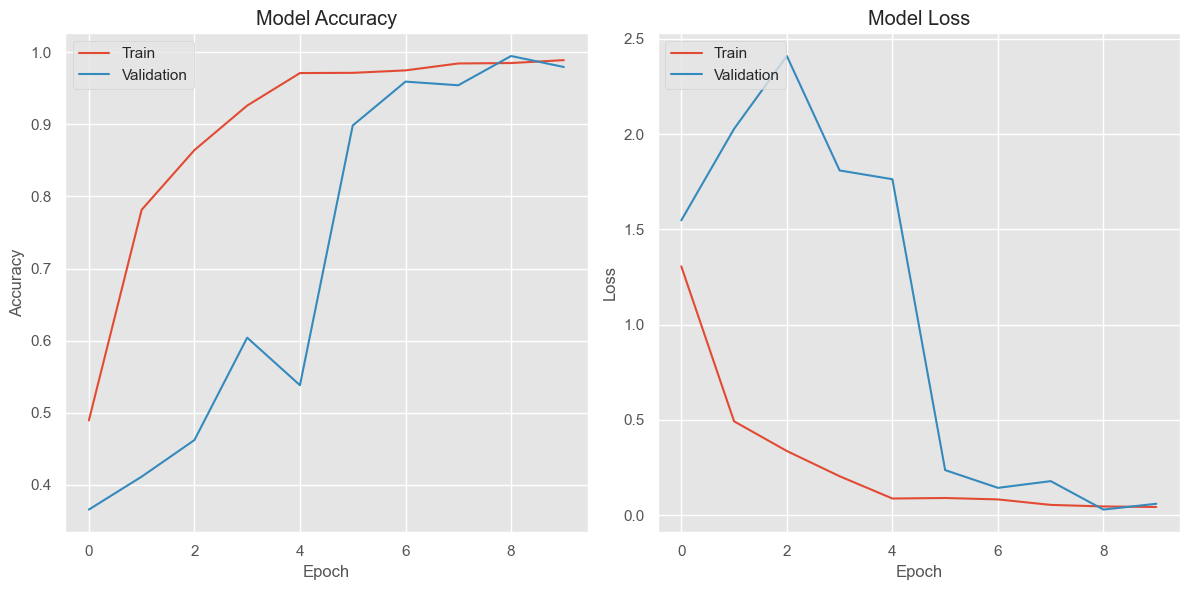

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


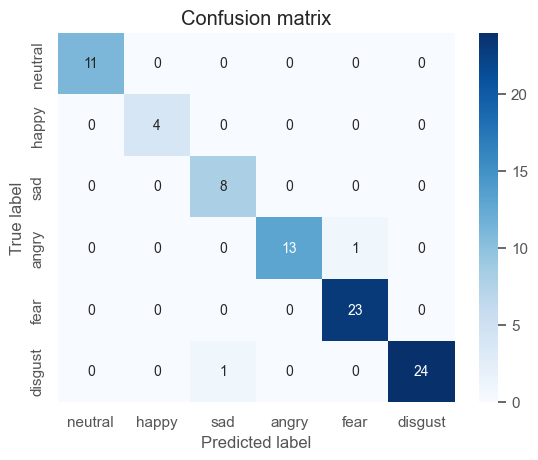

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9648 - loss: 0.1416
Validation Loss: 0.09579150378704071
Validation Accuracy: 0.9764705896377563
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Precision: 0.9764706
Recall: 0.9764706
F1-Score (neutral): 1.0
F1-Score (happy): 1.0
F1-Score (sad): 0.9411765
F1-Score (angry): 0.96296287
F1-Score (fear): 0.97872335
F1-Score (disgust): 0.9795917


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [58]:
summarize_history_accuracy(history_CLSTM)
plot_confusion_matrix(X_test, y_test_class, modelCLSTM )
model_info(modelCLSTM, X_test, y_test_class)

pr = modelCLSTM.predict(pda)
print(pr)
emotion_labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
predicted_emotion = emotion_labels[np.argmax(pr)]
print(predicted_emotion)